<a href="https://colab.research.google.com/github/rajavenkatesh04/Game-Sales-Predictions-/blob/main/sales_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
from sklearn.model_selection import train_test_split
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/x/games.csv'

In [ ]:
# Load your dataset
data= pd.read_csv(data_path)

In [ ]:
# Ensure 'Release date' is converted to datetime correctly
data['Release date'] = pd.to_datetime(data['Release date'], infer_datetime_format=True, errors='coerce')

# Check if there are any missing values in 'Release date' after conversion
print(data['Release date'].isna().sum())

# Extracting date components from 'Release date'
data['release_year'] = data['Release date'].dt.year
data['release_month'] = data['Release date'].dt.month
data['release_day'] = data['Release date'].dt.day
data['day_of_week'] = data['Release date'].dt.dayofweek
data['release_quarter'] = data['Release date'].dt.quarter

# Ensure the columns are created properly
print(data[['release_year', 'release_month', 'release_day', 'day_of_week', 'release_quarter']].head())


<ipython-input-8-2a349eb7032f>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['Release date'] = pd.to_datetime(data['Release date'], infer_datetime_format=True, errors='coerce')


130
   release_year  release_month  release_day  day_of_week  release_quarter
0        2008.0           10.0         21.0          1.0              4.0
1        2017.0           10.0         12.0          3.0              4.0
2        2021.0           11.0         17.0          2.0              4.0
3        2020.0            7.0         23.0          3.0              3.0
4        2020.0            2.0          3.0          0.0              1.0


In [ ]:
# Selecting features for the model
X = data[['Price', 'Peak CCU', 'DLC count', 'release_year', 'release_month', 'release_day', 'day_of_week']]
y = data['Estimated owners']

# Continue with your model training and evaluation as previously outlined


In [ ]:
# Convert 'Estimated owners' to numerical values
# Replace ranges with their midpoints (or another suitable representation)

def convert_range_to_midpoint(value):
    if isinstance(value, str):
        try:
            lower, upper = map(int, value.split(' - '))
            return (lower + upper) // 2
        except:
            return np.nan  # Handle cases where the format doesn't match by setting them to NaN
    else:
        return value  # If already a number, leave it unchanged

# Apply the conversion to the entire 'Estimated owners' column in the DataFrame
data['Estimated owners'] = data['Estimated owners'].apply(convert_range_to_midpoint)

# Fill NaN values with a suitable strategy (e.g., mean, median)
data['Estimated owners'] = data['Estimated owners'].fillna(data['Estimated owners'].mean())

# ... (rest of your code)

# Splitting data into train/test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example: Train a simple model (e.g., XGBoost)
import xgboost as xgb
model = xgb.XGBRegressor(objective='reg:squarederror')

# Ensure y_train is also converted to numerical before fitting
y_train = y_train.apply(convert_range_to_midpoint)
y_train = y_train.fillna(y_train.mean())

model.fit(X_train, y_train)

# ... (rest of your code)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Check for missing values
print(data.isnull().sum())

# Drop duplicates if any
data = data.drop_duplicates()

# Handle missing values
# For numerical columns, fill with median
numerical_cols = ['Price', 'Peak CCU', 'DLC count', 'Estimated owners']
for col in numerical_cols:
    data[col].fillna(data[col].median(), inplace=True)

# For categorical columns, fill with mode
categorical_cols = ['Name', 'Supported languages', 'Required age']
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Handle 'about the games' if necessary (e.g., fill NaN with empty string)
data['About the game'].fillna('', inplace=True)


AppID                             0
Name                              6
Release date                    130
Estimated owners                  0
Peak CCU                          0
Required age                      0
Price                             0
DLC count                         0
About the game                 3567
Supported languages               0
Full audio languages              0
Reviews                       75360
Header image                      0
Website                       45651
Support url                   43517
Support email                 13596
Windows                           0
Mac                               0
Linux                             0
Metacritic score                  0
Metacritic url                81191
User score                        0
Positive                          0
Negative                          0
Score rank                    85059
Achievements                      0
Recommendations                   0
Notes                       

<ipython-input-11-6f59240b6ecd>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
<ipython-input-11-6f59240b6ecd>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [ ]:
# Encode 'required age' if it's ordinal
# Assuming 'required age' is numerical or categorical without order
# If it's ordinal, use Label Encoding
# Here, we'll use One-Hot Encoding for simplicity

# Define categorical and numerical features
categorical_features = ['Name', 'Supported languages', 'Required age']
numerical_features = ['Price', 'Peak CCU', 'DLC count', 'release_year', 'release_month', 'release_day', 'day_of_week', 'release_quarter']

# Preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Check if 'About the game' column exists before proceeding
if 'About the game' in data.columns:
    # Initialize TF-IDF Vectorizer
    tfidf = TfidfVectorizer(max_features=100)  # Adjust max_features as needed

    # Fit and transform the text data
    tfidf_features = tfidf.fit_transform(data['About the game']).toarray()

    # Convert to DataFrame
    tfidf_df = pd.DataFrame(tfidf_features, columns=[f'about_tfidf_{i}' for i in range(tfidf_features.shape[1])])

    # Concatenate with the main DataFrame
    data = pd.concat([data, tfidf_df], axis=1)

    # Drop the original text column
    data.drop('About the game', axis=1, inplace=True)
else:
    print("Column 'About the game' not found in the DataFrame. Skipping TF-IDF feature extraction.")

Column 'About the game' not found in the DataFrame. Skipping TF-IDF feature extraction.


In [ ]:
# Convert 'Estimated owners' from Ranges to Numeric Values

def convert_range_to_midpoint(value):
    if isinstance(value, str):
        try:
            parts = value.split(' - ')
            lower = int(parts[0].replace(',', ''))
            upper = int(parts[1].replace(',', ''))
            return (lower + upper) / 2
        except:
            return np.nan  # Return NaN if format is incorrect
    else:
        return value  # If already a number, return as is

# Apply conversion
data['Estimated owners'] = data['Estimated owners'].apply(convert_range_to_midpoint)

# Handle any NaN values resulted from improper formats
data['Estimated owners'].fillna(data['Estimated owners'].median(), inplace=True)

# Preview the conversion
data['Estimated owners'].head()


<ipython-input-14-088f53f4db68>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Estimated owners'].fillna(data['Estimated owners'].median(), inplace=True)


,Estimated owners
0,10000
1,10000
2,10000
3,10000
4,10000


In [ ]:
## Process Text Data using TF-IDF

tfidf = TfidfVectorizer(max_features=100, stop_words='english')

# Ensure 'About the game' column exists. If not, skip this cell
if 'About the game' in data.columns:
    tfidf_matrix = tfidf.fit_transform(data['About the game'])

    # Convert TF-IDF matrix to DataFrame
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

    # Concatenate TF-IDF features with the main dataframe
    data = pd.concat([data, tfidf_df], axis=1)

    # Drop the original text column
    data.drop('About the game', axis=1, inplace=True)

    # Code to identify and rename duplicate columns

    # Check for duplicate columns
    duplicate_cols = data.columns[data.columns.duplicated()]
    print(f"Duplicate columns: {duplicate_cols}")

    # Rename duplicate columns in the 'data' DataFrame
    if len(duplicate_cols) > 0:
        for col in duplicate_cols:
            new_col_name = col + '_tfidf'  # Example renaming strategy
            data = data.rename(columns={col: new_col_name})

    # Update feature lists ONLY if duplicates were found
    if len(duplicate_cols) > 0:
        numerical_features = [col + '_tfidf' if col in duplicate_cols else col for col in numerical_features]
        categorical_features = [col + '_tfidf' if col in duplicate_cols else col for col in categorical_features]


# Define feature columns - Ensure you are using the correct columns from data
feature_cols = numerical_features + categorical_features + list(tfidf_df.columns)

# Split features and target - Use the updated 'data' DataFrame
X = data[feature_cols]

Duplicate columns: Index([], dtype='object')


In [ ]:
# 4. Prepare Features and Target Variable

# Define feature columns
feature_cols = numerical_cols + ['Price', 'Peak CCU', 'DLC count', 'release_year', 'release_month', 'release_day', 'day_of_week', 'release_quarter']+ categorical_cols + list(tfidf_df.columns)

# Define target variable
target_col = 'Estimated owners'

# Split features and target
X = data[feature_cols]
y = data[target_col]


In [ ]:
# 5. Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Code to identify and rename duplicate columns in X_train and X_test
# ONLY do this if you haven't done it for data above
# Check for duplicate columns
duplicate_cols = X_train.columns[X_train.columns.duplicated()]
print(f"Duplicate columns: {duplicate_cols}")

# Rename duplicate columns in the 'X_train' and 'X_test' DataFrames
if len(duplicate_cols) > 0:
    for col in duplicate_cols:
        new_col_name = col + '_tfidf'  # Example renaming strategy
        X_train = X_train.rename(columns={col: new_col_name})
        X_test = X_test.rename(columns={col: new_col_name})

# Instead of checking and renaming again, update 'numerical_features' and 'categorical_features' to reflect the updated column names:
numerical_features = [col if col in X_train.columns else col + '_tfidf' for col in numerical_features]
categorical_features = [col if col in X_train.columns else col + '_tfidf' for col in categorical_features]

Duplicate columns: Index(['Price', 'Peak CCU', 'DLC count'], dtype='object')


In [ ]:
# 18. Define and Apply Data Preprocessing

# Numerical features
numerical_features = numerical_cols + ['release_year', 'release_month', 'release_day', 'day_of_week', 'release_quarter']

# Categorical features
categorical_features = categorical_cols

# IMPORTANT: Update feature lists based on actual columns in X_train
# This ensures we are using the correct column names after potential renaming
numerical_features = [col if col in X_train.columns else col + '_tfidf' for col in numerical_features]
categorical_features = [col if col in X_train.columns else col + '_tfidf' for col in categorical_features]


# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='passthrough')  # 'passthrough' to include TF-IDF

# Define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100, learning_rate=0.1)

# Create the pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Before training, drop duplicate columns from X_train and X_test to avoid the error
X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]


# Train the model
model_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Price_tfidf',
                                                   'Peak CCU_tfidf',
                                                   'DLC count_tfidf',
                                                   'Estimated owners',
                                                   'release_year',
                                                   'release_month',
                                                   'release_day', 'day_of_week',
                                                   'release_quarter']),
                                                 ('cat',
                                                  Pipeline(ste...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# 8. Evaluate Model Performance

# Make predictions
y_pred = model_pipeline.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2 ): {r2:.2f}")


Model Performance:
Mean Squared Error (MSE): 1318.83
Root Mean Squared Error (RMSE): 36.32
R-squared (R2 ): 1.00


   Required age  Estimated owners
0             0      7.255317e+04
1             1      1.500000e+06
2             3      1.312500e+04
3             5      3.500000e+04
4             6      2.916667e+04


<ipython-input-68-2140486f811f>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Required age', y='Estimated owners', data=age_sales_data, palette='viridis')


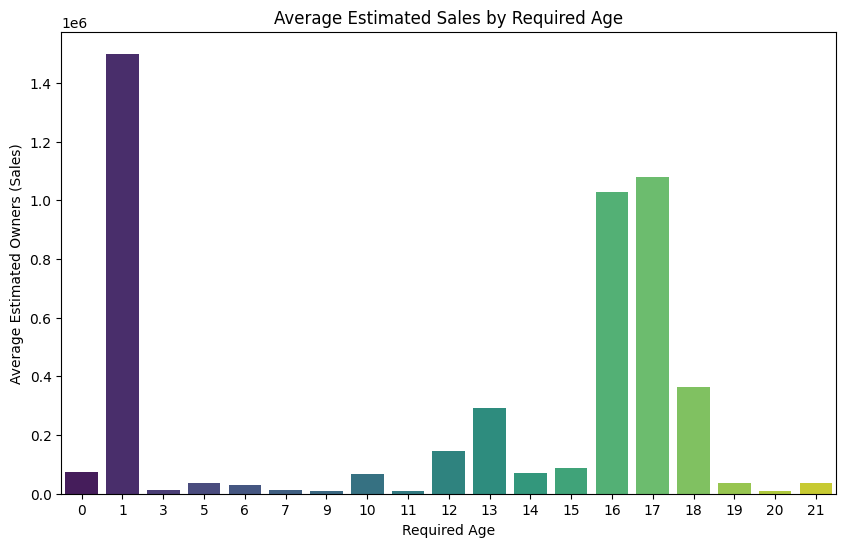

<ipython-input-68-2140486f811f>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Required age', y='Estimated owners', data=data, palette='coolwarm')


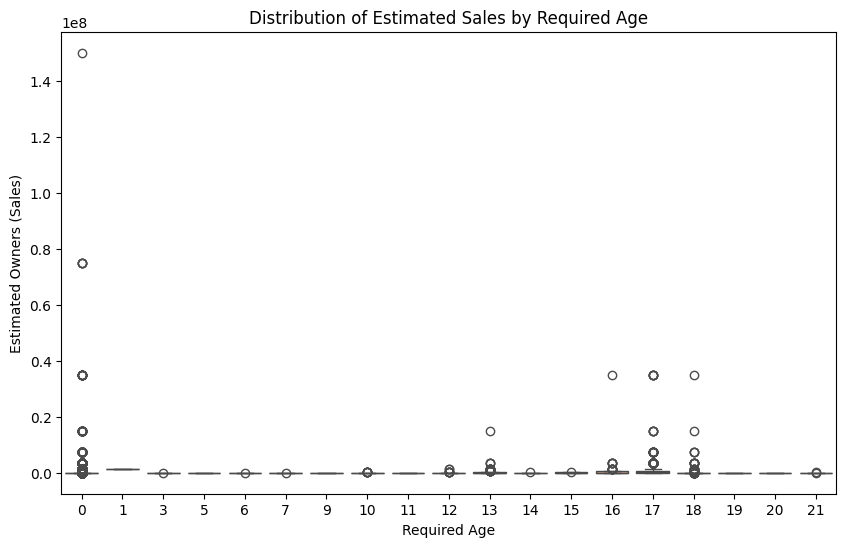

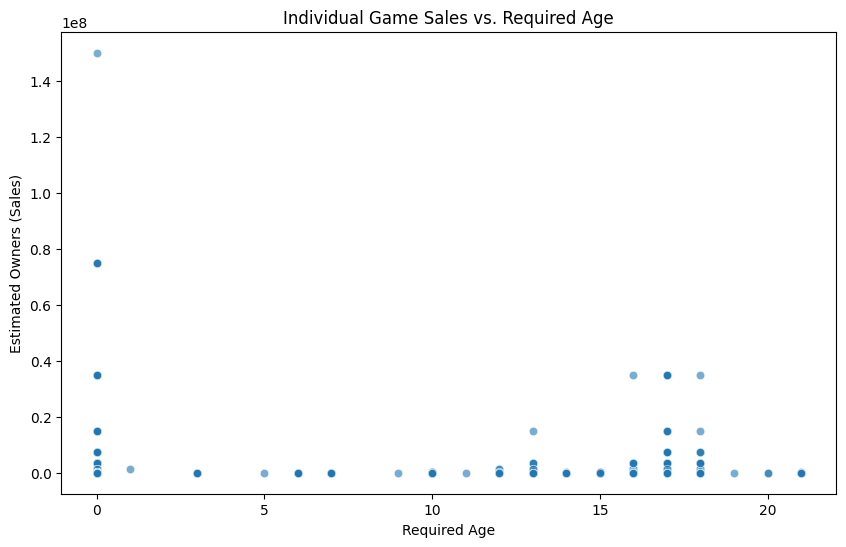

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure the 'Required age' and 'Estimated owners' columns are available in the DataFrame
# Replace range values in 'Estimated owners' if needed (assuming you've done this in preprocessing)
# If not already done, convert 'Estimated owners' from range to numeric midpoint:
def convert_range_to_midpoint(value):
    if isinstance(value, str):
        try:
            lower, upper = map(int, value.split(' - '))
            return (lower + upper) // 2
        except:
            return np.nan  # Handle cases where the format doesn't match by setting them to NaN
    else:
        return value  # If already a number, leave it unchanged

# Apply the conversion to the entire 'Estimated owners' column
data['Estimated owners'] = data['Estimated owners'].apply(convert_range_to_midpoint)

# Fill NaN values if any
data['Estimated owners'] = data['Estimated owners'].fillna(data['Estimated owners'].median())

# Group by 'Required age' and calculate average estimated sales
age_sales_data = data.groupby('Required age')['Estimated owners'].mean().reset_index()

# Sort by age for better visualization
age_sales_data = age_sales_data.sort_values(by='Required age')

# Display the first few rows of the aggregated data
print(age_sales_data.head())

# Bar plot for Required Age vs Average Estimated Sales
plt.figure(figsize=(10, 6))
sns.barplot(x='Required age', y='Estimated owners', data=age_sales_data, palette='viridis')
plt.title('Average Estimated Sales by Required Age')
plt.xlabel('Required Age')
plt.ylabel('Average Estimated Owners (Sales)')
plt.show()

# Box plot to visualize the distribution of sales across age ratings
plt.figure(figsize=(10, 6))
sns.boxplot(x='Required age', y='Estimated owners', data=data, palette='coolwarm')
plt.title('Distribution of Estimated Sales by Required Age')
plt.xlabel('Required Age')
plt.ylabel('Estimated Owners (Sales)')
plt.show()

# Scatter plot for individual game sales against required age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Required age', y='Estimated owners', data=data, alpha=0.6)
plt.title('Individual Game Sales vs. Required Age')
plt.xlabel('Required Age')
plt.ylabel('Estimated Owners (Sales)')
plt.show()


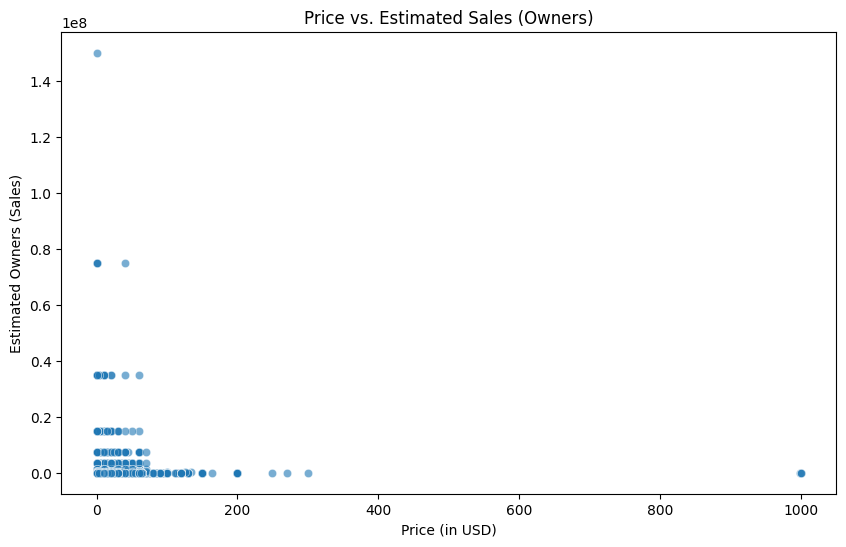

<ipython-input-69-411ecf60f97f>:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_sales_data = data.groupby('Price Range')['Estimated owners'].mean().reset_index()
<ipython-input-69-411ecf60f97f>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Price Range', y='Estimated owners', data=price_sales_data, palette='magma')


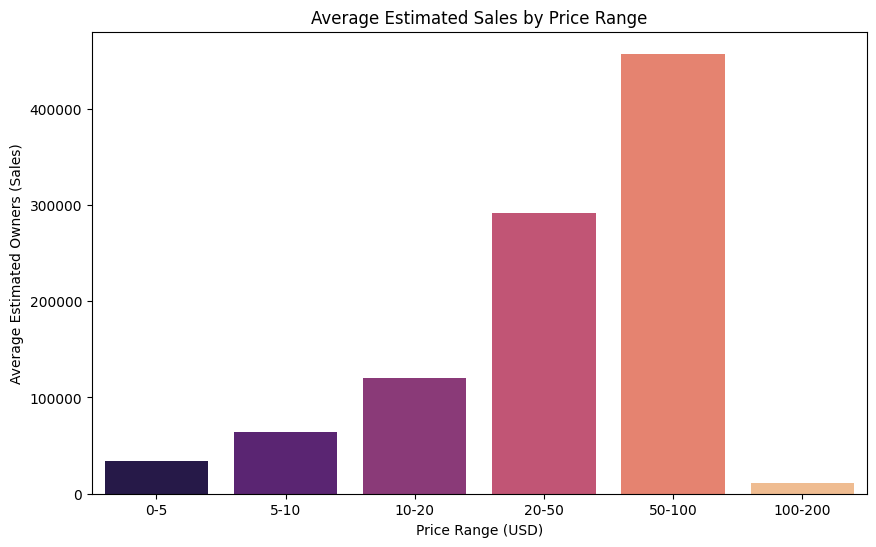

<ipython-input-69-411ecf60f97f>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Price Range', y='Estimated owners', data=data, palette='coolwarm')


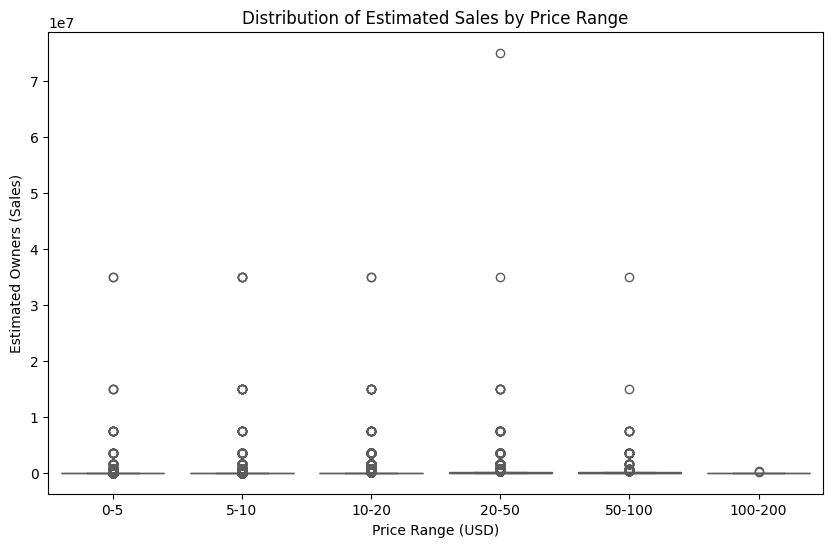

Correlation between Price and Estimated Owners:
                      Price  Estimated owners
Price             1.000000          0.035169
Estimated owners  0.035169          1.000000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure that 'Price' and 'Estimated owners' columns are available in the DataFrame
# 'Estimated owners' is already converted from range to numeric midpoint as shown before
# If not, you can apply the same conversion method used for 'Required age'

# Check for any missing values and fill them (if needed)
data['Price'] = data['Price'].fillna(data['Price'].median())
data['Estimated owners'] = data['Estimated owners'].fillna(data['Estimated owners'].median())

# Scatter plot: Price vs. Estimated Owners
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price', y='Estimated owners', data=data, alpha=0.6)
plt.title('Price vs. Estimated Sales (Owners)')
plt.xlabel('Price (in USD)')
plt.ylabel('Estimated Owners (Sales)')
plt.show()

# Grouping by price ranges to understand sales trends
# You can bin the prices into ranges for better visualization and aggregation
data['Price Range'] = pd.cut(data['Price'], bins=[0, 5, 10, 20, 50, 100, 200], labels=['0-5', '5-10', '10-20', '20-50', '50-100', '100-200'])

# Group by price range and calculate average sales
price_sales_data = data.groupby('Price Range')['Estimated owners'].mean().reset_index()

# Bar plot: Average Sales per Price Range
plt.figure(figsize=(10, 6))
sns.barplot(x='Price Range', y='Estimated owners', data=price_sales_data, palette='magma')
plt.title('Average Estimated Sales by Price Range')
plt.xlabel('Price Range (USD)')
plt.ylabel('Average Estimated Owners (Sales)')
plt.show()

# Box plot to visualize the distribution of sales across price ranges
plt.figure(figsize=(10, 6))
sns.boxplot(x='Price Range', y='Estimated owners', data=data, palette='coolwarm')
plt.title('Distribution of Estimated Sales by Price Range')
plt.xlabel('Price Range (USD)')
plt.ylabel('Estimated Owners (Sales)')
plt.show()

# For deeper analysis, calculate the correlation between price and sales
correlation = data[['Price', 'Estimated owners']].corr()
print("Correlation between Price and Estimated Owners:\n", correlation)


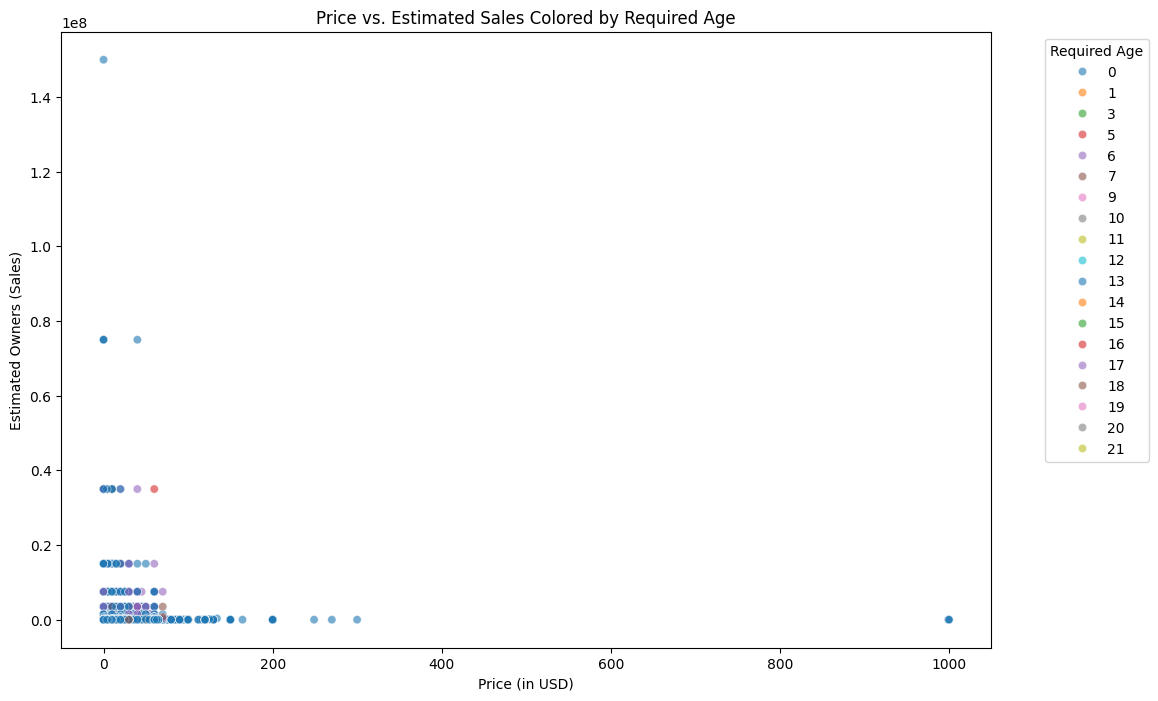

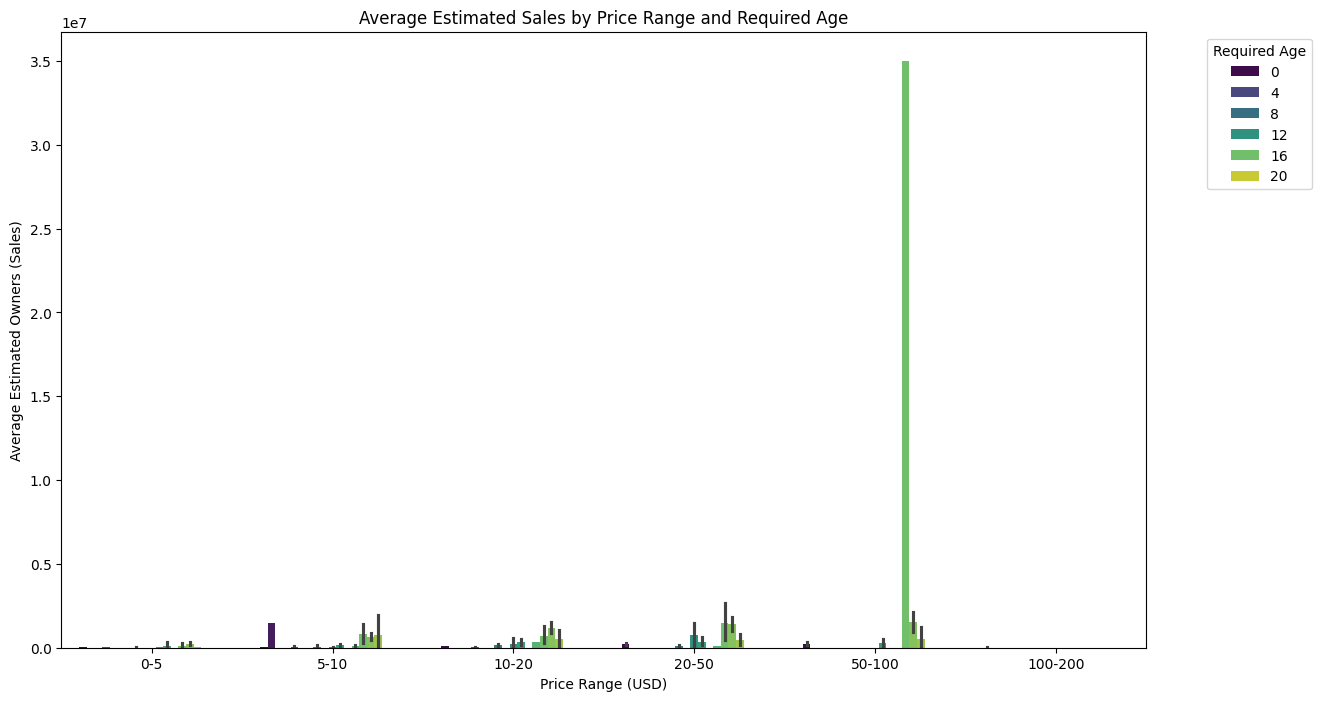

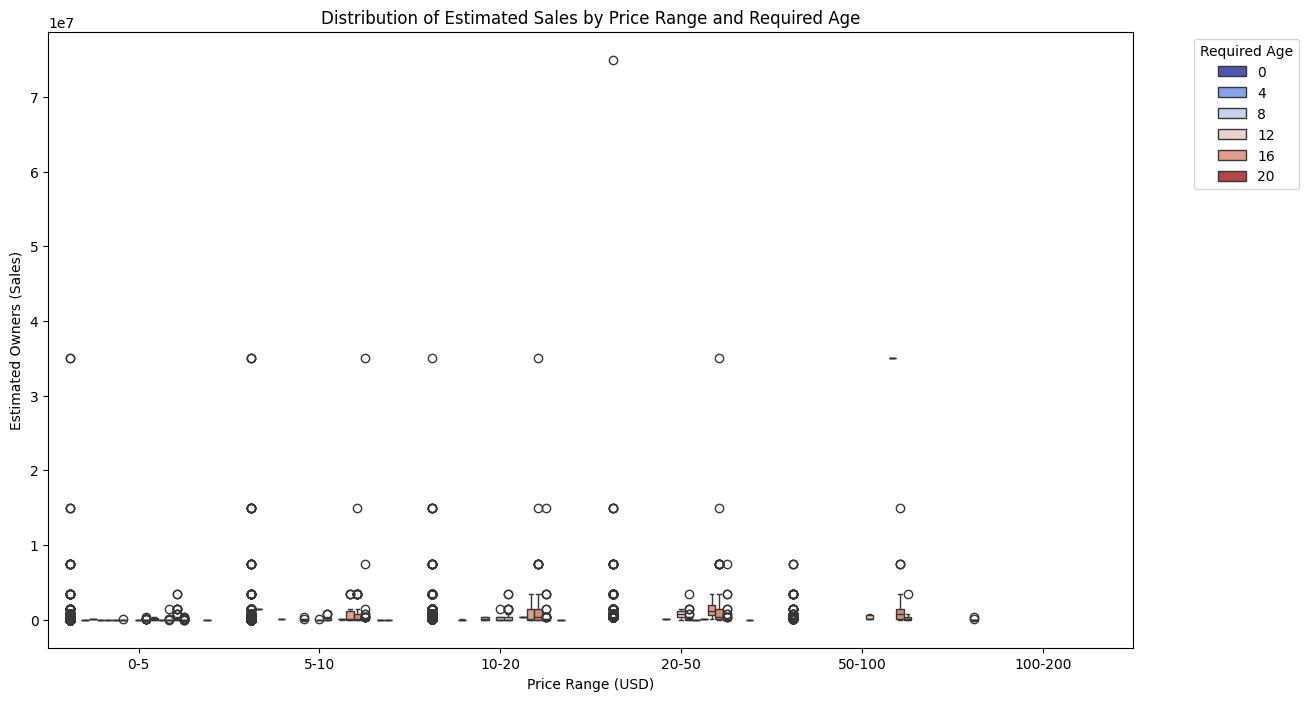

<Figure size 1400x800 with 0 Axes>

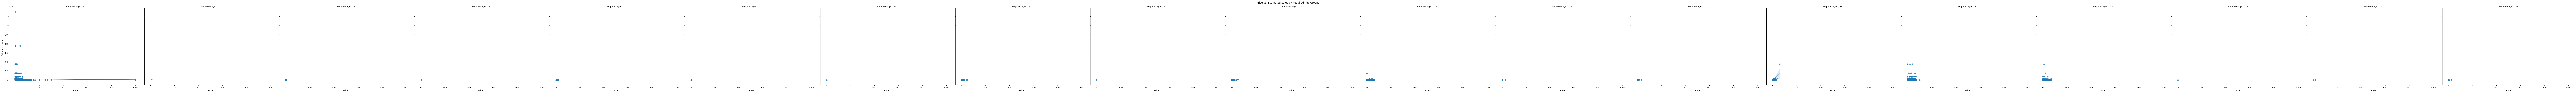

Correlation between Price and Estimated Owners: 0.03516905699597846


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data preparation
# Fill missing values for price and estimated owners if not already done
data['Price'] = data['Price'].fillna(data['Price'].median())
data['Estimated owners'] = data['Estimated owners'].fillna(data['Estimated owners'].median())

# Create a Price Range column for grouping
data['Price Range'] = pd.cut(data['Price'], bins=[0, 5, 10, 20, 50, 100, 200], labels=['0-5', '5-10', '10-20', '20-50', '50-100', '100-200'])

# Scatter Plot: Price vs. Estimated Sales colored by Age
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Price', y='Estimated owners', hue='Required age', palette='tab10', alpha=0.6, data=data)
plt.title('Price vs. Estimated Sales Colored by Required Age')
plt.xlabel('Price (in USD)')
plt.ylabel('Estimated Owners (Sales)')
plt.legend(title='Required Age', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Bar Plot: Average Sales by Price Range and Required Age
plt.figure(figsize=(14, 8))
sns.barplot(x='Price Range', y='Estimated owners', hue='Required age', data=data, palette='viridis')
plt.title('Average Estimated Sales by Price Range and Required Age')
plt.xlabel('Price Range (USD)')
plt.ylabel('Average Estimated Owners (Sales)')
plt.legend(title='Required Age', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Box Plot: Distribution of Sales by Price Range and Required Age
plt.figure(figsize=(14, 8))
sns.boxplot(x='Price Range', y='Estimated owners', hue='Required age', data=data, palette='coolwarm')
plt.title('Distribution of Estimated Sales by Price Range and Required Age')
plt.xlabel('Price Range (USD)')
plt.ylabel('Estimated Owners (Sales)')
plt.legend(title='Required Age', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Scatter Plot with Regression Line for Price vs Estimated Sales by Age Groups
plt.figure(figsize=(14, 8))
sns.lmplot(x='Price', y='Estimated owners', col='Required age', data=data, aspect=1.5, height=6, palette='tab10')
plt.suptitle('Price vs. Estimated Sales by Required Age Groups', y=1.02)
plt.show()

# Correlation analysis for Price and Estimated Owners
correlation_price_sales = data[['Price', 'Estimated owners']].corr().iloc[0, 1]
print("Correlation between Price and Estimated Owners:", correlation_price_sales)
